In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
warnings.filterwarnings("ignore")

With the groupings done, we can proceed to model training. The fact that male data and female data have a little in common is an indication that we should bisect the passengers left out of groups into males and females, and train models to predict them respectively.

In [2]:
data = pd.read_csv("data/clean/data.csv")
train_m, test_m = data[:891].loc[(data["Sex"] == "male") & (data.WCLive.isnull())], data[891:].loc[(data["Sex"] == "male") & (data.WCLive.isnull())]
train_f, test_f = data[:891].loc[(data["Sex"] == "female") & (data.WCLive.isnull())], data[891:].loc[(data["Sex"] == "female") & (data.WCLive.isnull())]

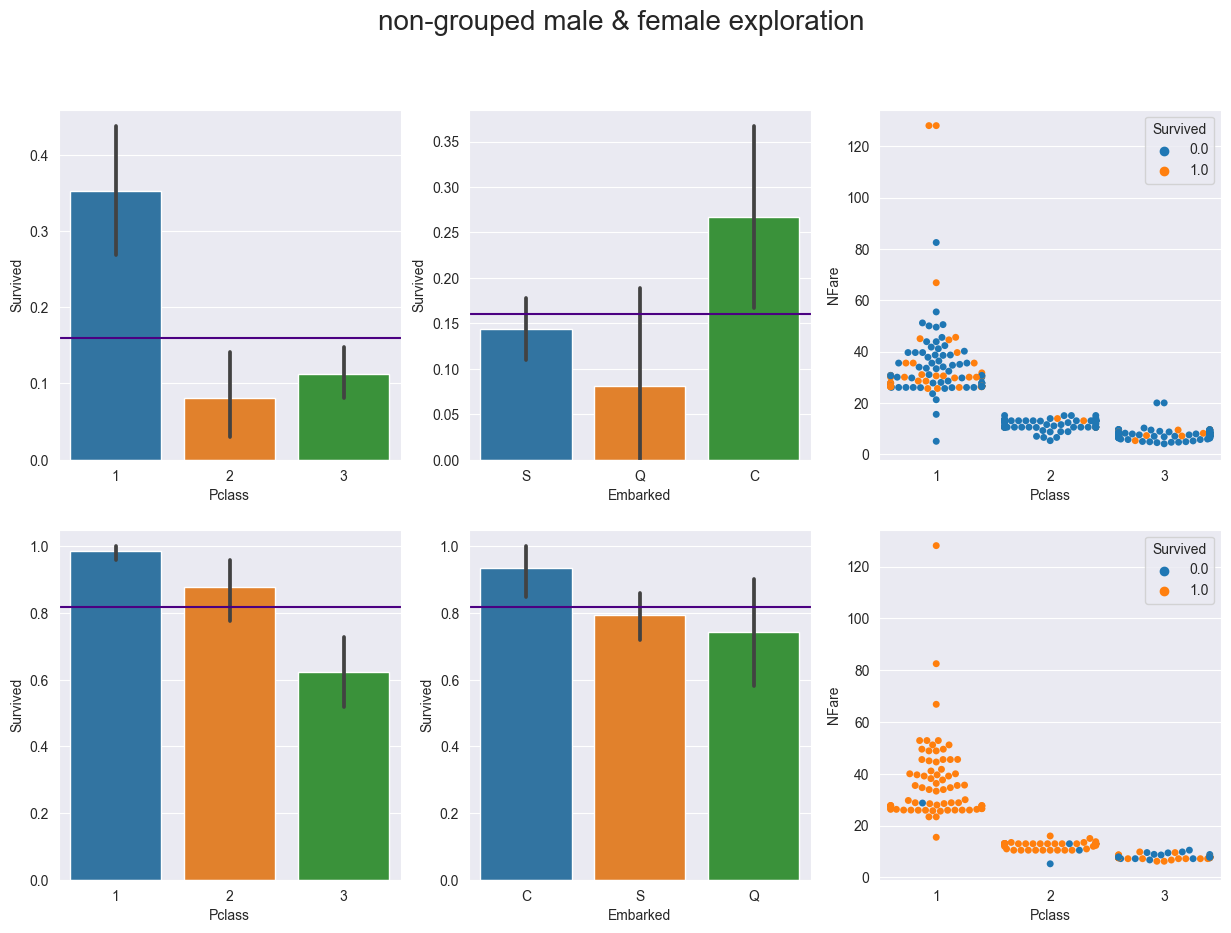

In [3]:
_, ax = plt.subplots(2, 3, figsize=[15, 10])
plt.suptitle("non-grouped male & female exploration", fontsize=20)
sns.barplot(data=train_m, x="Pclass", y="Survived", ax=ax[0][0])
ax[0][0].axhline(y=train_m.Survived.mean(), color="indigo")
sns.barplot(data=train_m, x="Embarked", y="Survived", ax=ax[0][1])
ax[0][1].axhline(y=train_m.Survived.mean(), color="indigo")
sns.swarmplot(data=train_m, x="Pclass", y="NFare", hue="Survived", ax=ax[0][2])
sns.barplot(data=train_f, x="Pclass", y="Survived", ax=ax[1][0])
ax[1][0].axhline(y=train_f.Survived.mean(), color="indigo")
sns.barplot(data=train_f, x="Embarked", y="Survived", ax=ax[1][1])
ax[1][1].axhline(y=train_f.Survived.mean(), color="indigo")
sns.swarmplot(data=train_f, x="Pclass", y="NFare", hue="Survived", ax=ax[1][2])
plt.show()

Overall, the male data visualization does not present too many insights except that we have a better chance to predict $Survived$ with the feature $NFare$ and $Pclass$ (or $NFare$ alone) within the interval of [20, 50]. On the other hand, the female data visualization provides more insights, in that, with $NFare$ and $Pclass$ (or $NFare$ alone), it is easy to predict $Survived$. Let's try using $NFare$.

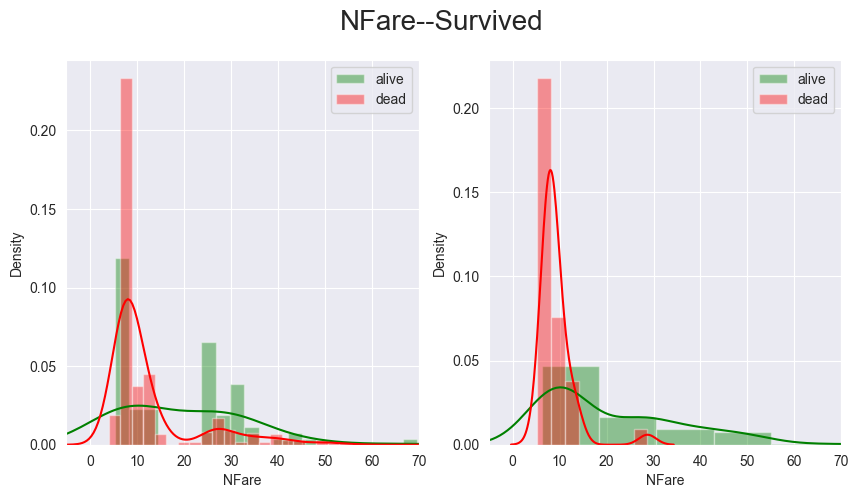

In [4]:
m_s, m_d = train_m.loc[train_m["Survived"] == 1, "NFare"], train_m.loc[train_m["Survived"] == 0, "NFare"]
f_s, f_d = train_f.loc[train_f["Survived"] == 1, "NFare"], train_f.loc[train_f["Survived"] == 0, "NFare"]
_, ax = plt.subplots(1, 2, figsize=[10, 5])
plt.suptitle("NFare--Survived", fontsize=20)
sns.distplot(m_s, bins=40, label="alive", ax=ax[0], color="g")
sns.distplot(m_d, bins=32, label="dead", ax=ax[0], color="r")
ax[0].set_xlim(-5, 70)
ax[0].legend()
sns.distplot(f_s, bins=10, label="alive", ax=ax[1], color="g")
sns.distplot(f_d, bins=8, label="dead", ax=ax[1], color="r")
ax[1].set_xlim(-5, 70)
ax[1].legend()
plt.show()

**Male data model training**
There are definitely regions where it's easy to separate $Survived$. With these understandings, it'll be wise to include $Pclass$, $Embarked$ and $NFare$ in the model training.

In [5]:
x_m, y_m = train_m[["Pclass", "Embarked", "NFare"]], train_m["Survived"]
x_test = test_m[["Pclass", "Embarked", "NFare"]]
data_prep = ColumnTransformer(transformers=[
    ("num", Pipeline(steps=[("fill", SimpleImputer(strategy="mean")), ("norm", StandardScaler(with_mean=True))]), ["NFare"]),
    ("cat", Pipeline(steps=[("fill", SimpleImputer(strategy="most_frequent")), ("code", OneHotEncoder(handle_unknown="ignore"))]), ["Pclass", "Embarked"])
])
fold, state = StratifiedKFold(n_splits=15), 666
algorithms = [
    SVC(random_state=state), DecisionTreeClassifier(random_state=state), KNeighborsClassifier(), MLPClassifier(random_state=state),
    RandomForestClassifier(random_state=state), AdaBoostClassifier(DecisionTreeClassifier(random_state=state), random_state=state, learning_rate=0.01)
]
cv_a_m, cv_p_m, cv_r_m = [], [], []
for a in algorithms:
    c = Pipeline(steps=[
        ("prep", data_prep),
        ("train", a)
    ])
    cv_a_m.append(cross_val_score(c, x_m, y_m, scoring="accuracy", cv=fold, n_jobs=-1))
    cv_p_m.append(cross_val_score(c, x_m, y_m, scoring="precision", cv=fold, n_jobs=-1))
    cv_r_m.append(cross_val_score(c, x_m, y_m, scoring="recall", cv=fold, n_jobs=-1))

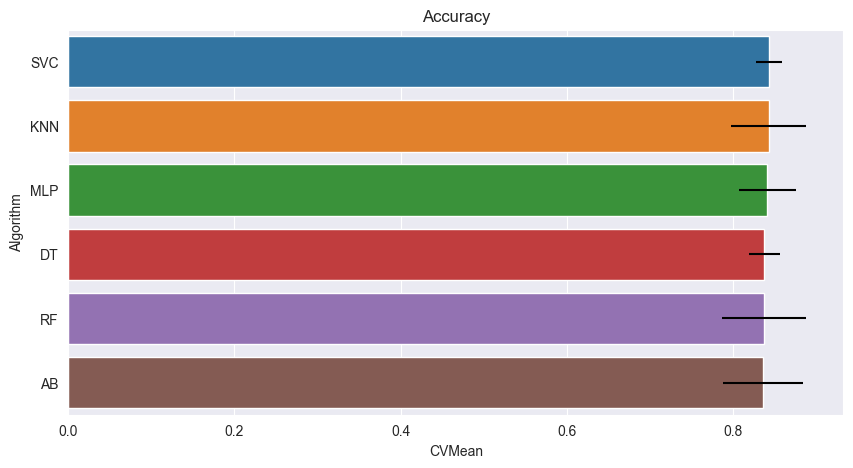

In [6]:
cv_m_m, cv_s_m = [], []
for s in cv_a_m:
    cv_m_m.append(s.mean())
    cv_s_m.append(s.std())
cv_result_m = pd.DataFrame({"CVMean": cv_m_m, "CVStd": cv_s_m, "Algorithm": ["SVC", "DT", "KNN", "MLP", "RF", "AB"]})
plt.figure(figsize=[10, 5])
sns.barplot(data=cv_result_m, x="CVMean", y="Algorithm", order=cv_result_m.sort_values("CVMean", ascending=False).Algorithm, **{"xerr": cv_s_m}).set_title("Accuracy")
plt.show()

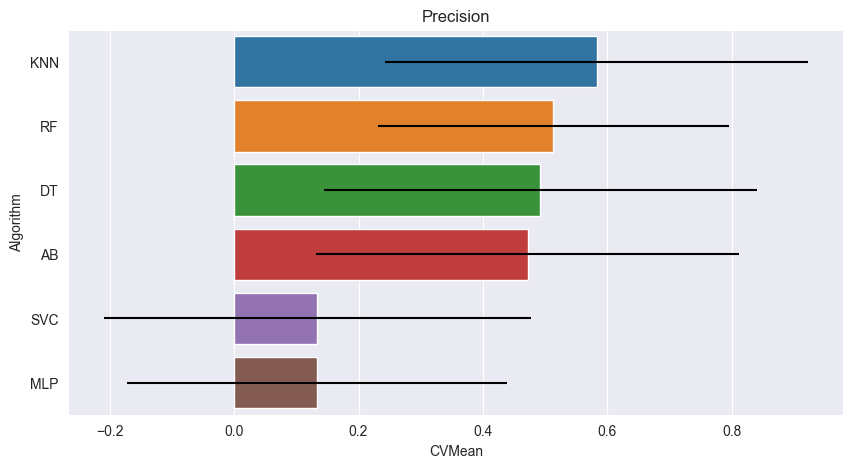

In [7]:
cv_m_m, cv_s_m = [], []
for s in cv_p_m:
    cv_m_m.append(s.mean())
    cv_s_m.append(s.std())
cv_result_m = pd.DataFrame({"CVMean": cv_m_m, "CVStd": cv_s_m, "Algorithm": ["SVC", "DT", "KNN", "MLP", "RF", "AB"]})
plt.figure(figsize=[10, 5])
sns.barplot(data=cv_result_m, x="CVMean", y="Algorithm", order=cv_result_m.sort_values("CVMean", ascending=False).Algorithm, **{"xerr": cv_s_m}).set_title("Precision")
plt.show()

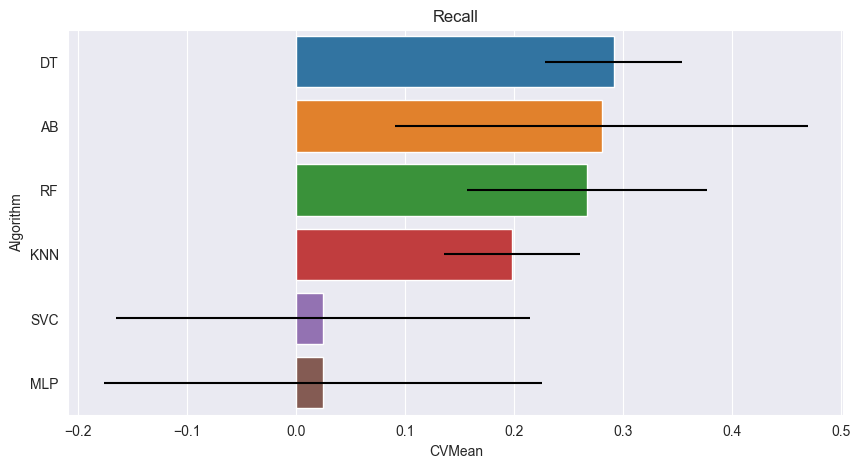

In [8]:
cv_m_m, cv_s_m = [], []
for s in cv_r_m:
    cv_m_m.append(s.mean())
    cv_s_m.append(s.std())
cv_result_m = pd.DataFrame({"CVMean": cv_m_m, "CVStd": cv_s_m, "Algorithm": ["SVC", "DT", "KNN", "MLP", "RF", "AB"]})
plt.figure(figsize=[10, 5])
sns.barplot(data=cv_result_m, x="CVMean", y="Algorithm", order=cv_result_m.sort_values("CVMean", ascending=False).Algorithm, **{"xerr": cv_s_m}).set_title("Recall")
plt.show()

From above metrics, I decided to use KNN, DT, RF, AB. Let's do some gridsearch.

In [9]:
KNN_model_m = Pipeline(steps=[
    ("prep", data_prep),
    ("train", KNeighborsClassifier())
])
KNN_grid_m = {
    "train__n_neighbors": range(1, 16)
}
KNN_search_m = GridSearchCV(KNN_model_m, param_grid=KNN_grid_m, cv=fold, scoring="accuracy", verbose=1).fit(x_m, y_m)
print(KNN_search_m.best_score_)
KNN_best_m = KNN_search_m.best_estimator_

Fitting 15 folds for each of 15 candidates, totalling 225 fits
0.854814814814815


In [10]:
DT_model_m = Pipeline(steps=[
    ("prep", data_prep),
    ("train", DecisionTreeClassifier(random_state=state))
])
DT_grid_m = {
    "train__criterion": ["gini", "entropy"],
    "train__max_depth":[4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
}
DT_search_m = GridSearchCV(DT_model_m, param_grid=DT_grid_m, cv=fold, scoring="accuracy", verbose=1).fit(x_m, y_m)
print(DT_search_m.best_score_)
DT_best_m = DT_search_m.best_estimator_

Fitting 15 folds for each of 36 candidates, totalling 540 fits
0.8437566137566138


In [11]:
RF_model_m = Pipeline(steps=[
    ("prep", data_prep),
    ("train", RandomForestClassifier(random_state=state))
])
RF_grid_m = {
    "train__criterion": ["gini"],
    "train__max_depth": [None],
    "train__bootstrap": [False],
    "train__max_features": [1, 3, 10],
    "train__min_samples_split": [2, 3, 10],
    "train__min_samples_leaf": [1, 3, 10],
    "train__n_estimators": [100, 300]
}
RF_search_m = GridSearchCV(RF_model_m, param_grid=RF_grid_m, cv=fold, scoring="accuracy", verbose=1).fit(x_m, y_m)
print(RF_search_m.best_score_)
RF_best_m = RF_search_m.best_estimator_

Fitting 15 folds for each of 54 candidates, totalling 810 fits
0.8437037037037037


In [12]:
AB_model_m = Pipeline(steps=[
    ("prep", data_prep),
    ("train", AdaBoostClassifier(DecisionTreeClassifier(), random_state=state))
])
AB_grid_m = {
    "train__base_estimator__criterion" : ["gini", "entropy"],
    "train__base_estimator__splitter" :   ["best", "random"],
    "train__algorithm" : ["SAMME","SAMME.R"],
    "train__n_estimators" :[1,2],
    "train__learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]
}
AB_search_m = GridSearchCV(AB_model_m, param_grid=AB_grid_m, cv=fold, scoring="accuracy", verbose=1).fit(x_m, y_m)
print(AB_search_m.best_score_)
AB_best_m = AB_search_m.best_estimator_

Fitting 15 folds for each of 112 candidates, totalling 1680 fits
0.8417989417989419


In [13]:
SVC_model_m = Pipeline(steps=[
    ("prep", data_prep),
    ("train", SVC(random_state=state, probability=True))
])
SVC_grid_m = {
    "train__kernel": ["rbf"],
    "train__gamma": [0.001, 0.01, 0.1, 1],
    "train__C": [1, 10, 50, 100, 200, 300, 1000]
}
SVC_search_m = GridSearchCV(SVC_model_m, param_grid=SVC_grid_m, cv=fold, scoring="accuracy", verbose=1).fit(x_m, y_m)
print(SVC_search_m.best_score_)
SVC_best_m = SVC_search_m.best_estimator_

Fitting 15 folds for each of 28 candidates, totalling 420 fits
0.8437037037037037


KNN is the best.

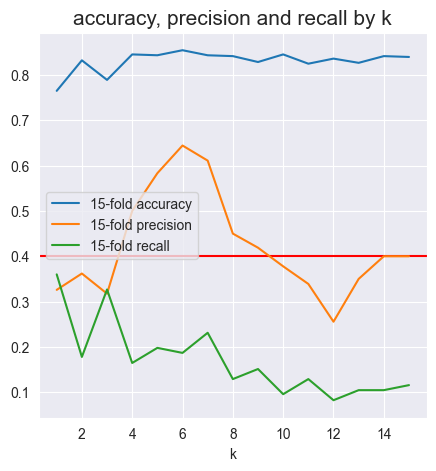

In [14]:
accuracy_m, precision_m, recall_m = [], [], []
for k in np.arange(1, 16):
    clf_1 = Pipeline(steps=[
        ("prep", data_prep),
        ("train", KNeighborsClassifier(n_neighbors=k))
    ])
    accuracy_m.append(cross_val_score(clf_1, x_m, y_m, cv=fold, scoring="accuracy").mean())
    precision_m.append(cross_val_score(clf_1, x_m, y_m, cv=fold, scoring="precision").mean())
    recall_m.append(cross_val_score(clf_1, x_m, y_m, cv=fold, scoring="recall").mean())
plt.figure(figsize=[5, 5])
plt.axhline(y=0.4, color="r")
plt.plot(range(1,16), accuracy_m, label="15-fold accuracy")
plt.plot(range(1,16), precision_m, label="15-fold precision")
plt.plot(range(1,16), recall_m, label="15-fold recall")
plt.xlabel("k")
plt.title("accuracy, precision and recall by k", fontsize=15)
plt.legend()
plt.show()

In [15]:
pipeline_m = Pipeline(steps=[
    ("prep", data_prep),
    ("vote", VotingClassifier([("1st", KNeighborsClassifier(n_neighbors=1)), ("2nd", KNeighborsClassifier(n_neighbors=3)), ("3rd", KNeighborsClassifier(n_neighbors=15))]))
]).fit(x_m, y_m)
predict_m = pipeline_m.predict(x_test)
data.loc[891:, "Predict"][(data["Sex"] == "male") & (data.WCLive.isnull())] = predict_m

**Female data model training**

In [16]:
x_f, y_f = train_f[["Pclass", "Embarked", "NFare"]], train_f["Survived"]
cv_a_f, cv_p_f, cv_r_f = [], [], []
fold =StratifiedKFold(n_splits=9)
for a in algorithms:
    c = Pipeline(steps=[
        ("prep", data_prep),
        ("train", a)
    ])
    cv_a_f.append(cross_val_score(c, x_f, y_f, scoring="accuracy", cv=fold, n_jobs=-1))
    cv_p_f.append(cross_val_score(c, x_f, y_f, scoring="precision", cv=fold, n_jobs=-1))
    cv_r_f.append(cross_val_score(c, x_f, y_f, scoring="recall", cv=fold, n_jobs=-1))

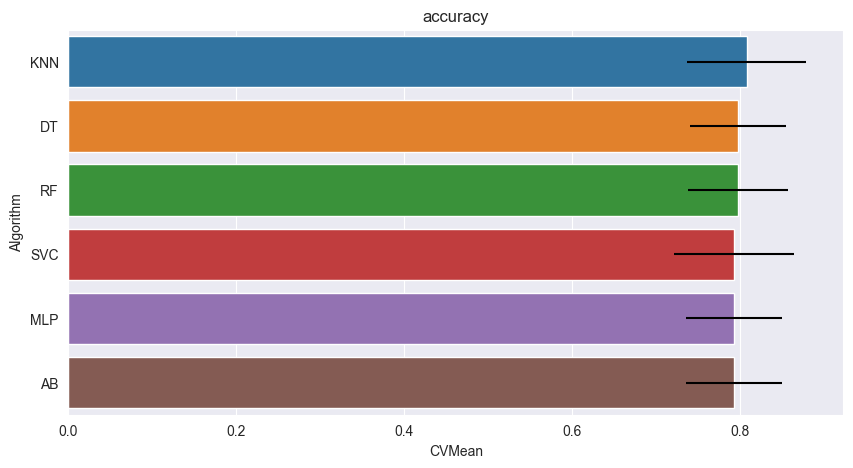

In [17]:
cv_m_f, cv_s_f = [], []
for s in cv_a_f:
    cv_m_f.append(s.mean())
    cv_s_f.append(s.std())
cv_result_f = pd.DataFrame({"CVMean": cv_m_f, "CVStd": cv_s_f, "Algorithm": ["SVC", "DT", "KNN", "MLP", "RF", "AB"]})
plt.figure(figsize=[10, 5])
sns.barplot(data=cv_result_f, x="CVMean", y="Algorithm", order=cv_result_f.sort_values("CVMean", ascending=False).Algorithm, **{"xerr": cv_s_f}).set_title("accuracy")
plt.show()

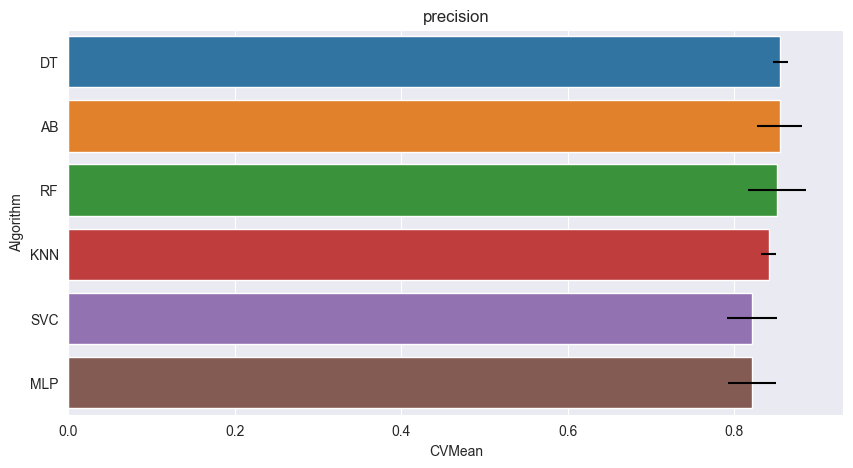

In [18]:
cv_m_f, cv_s_f = [], []
for s in cv_p_f:
    cv_m_f.append(s.mean())
    cv_s_f.append(s.std())
cv_result_f = pd.DataFrame({"CVMean": cv_m_f, "CVStd": cv_s_f, "Algorithm": ["SVC", "DT", "KNN", "MLP", "RF", "AB"]})
plt.figure(figsize=[10, 5])
sns.barplot(data=cv_result_f, x="CVMean", y="Algorithm", order=cv_result_f.sort_values("CVMean", ascending=False).Algorithm, **{"xerr": cv_s_f}).set_title("precision")
plt.show()

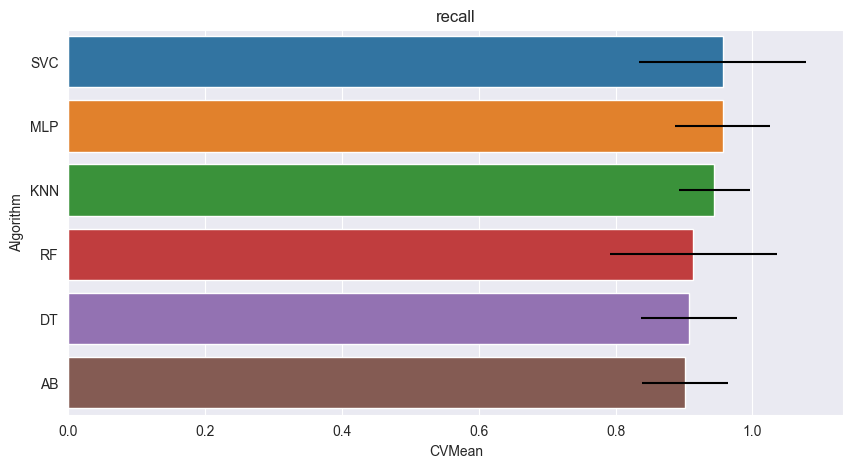

In [19]:
cv_m_f, cv_s_f = [], []
for s in cv_r_f:
    cv_m_f.append(s.mean())
    cv_s_f.append(s.std())
cv_result_f = pd.DataFrame({"CVMean": cv_m_f, "CVStd": cv_s_f, "Algorithm": ["SVC", "DT", "KNN", "MLP", "RF", "AB"]})
plt.figure(figsize=[10, 5])
sns.barplot(data=cv_result_f, x="CVMean", y="Algorithm", order=cv_result_f.sort_values("CVMean", ascending=False).Algorithm, **{"xerr": cv_s_f}).set_title("recall")
plt.show()

Again, some grid search.

In [20]:
SVC_model_f = Pipeline(steps=[
    ("prep", data_prep),
    ("train", SVC(random_state=state, probability=True))
])
SVC_grid_f = {
    "train__kernel": ["rbf"],
    "train__gamma": [0.001, 0.01, 0.1, 1],
    "train__C": [1, 10, 50, 100, 200, 300, 1000]
}
SVC_search_f = GridSearchCV(SVC_model_f, param_grid=SVC_grid_f, cv=fold, scoring="accuracy", verbose=1).fit(x_f, y_f)
print(SVC_search_f.best_score_)
SVC_best_f = SVC_search_f.best_estimator_

Fitting 9 folds for each of 28 candidates, totalling 252 fits
0.8181818181818182


In [21]:
DT_model_f = Pipeline(steps=[
    ("prep", data_prep),
    ("train", DecisionTreeClassifier(random_state=state))
])
DT_grid_f = {
    "train__criterion": ["gini", "entropy"],
    "train__max_depth":[4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
}
DT_search_f = GridSearchCV(DT_model_f, param_grid=DT_grid_f, cv=fold, scoring="accuracy", verbose=1).fit(x_f, y_f)
print(DT_search_f.best_score_)
DT_best_f = DT_search_f.best_estimator_

Fitting 9 folds for each of 36 candidates, totalling 324 fits
0.8080808080808081


In [22]:
KNN_model_f = Pipeline(steps=[
    ("prep", data_prep),
    ("train", KNeighborsClassifier())
])
KNN_grid_f = {
    "train__n_neighbors": range(1, 16)
}
KNN_search_f = GridSearchCV(KNN_model_f, param_grid=KNN_grid_f, cv=fold, scoring="accuracy", verbose=1).fit(x_f, y_f)
print(KNN_search_f.best_score_)
KNN_best_f = KNN_search_f.best_estimator_

Fitting 9 folds for each of 15 candidates, totalling 135 fits
0.8232323232323232


In [23]:
RF_model_f = Pipeline(steps=[
    ("prep", data_prep),
    ("train", RandomForestClassifier(random_state=state))
])
RF_grid_f = {
    "train__criterion": ["gini"],
    "train__max_depth": [None],
    "train__bootstrap": [False],
    "train__max_features": [1, 3, 10],
    "train__min_samples_split": [2, 3, 10],
    "train__min_samples_leaf": [1, 3, 10],
    "train__n_estimators": [100, 300]
}
RF_search_f = GridSearchCV(RF_model_f, param_grid=RF_grid_f, cv=fold, scoring="accuracy", verbose=1).fit(x_f, y_f)
print(RF_search_f.best_score_)
RF_best_f = RF_search_f.best_estimator_

Fitting 9 folds for each of 54 candidates, totalling 486 fits
0.8282828282828283


In [24]:
AB_model_f = Pipeline(steps=[
    ("prep", data_prep),
    ("train", AdaBoostClassifier(DecisionTreeClassifier(), random_state=state))
])
AB_grid_f = {
    "train__base_estimator__criterion" : ["gini", "entropy"],
    "train__base_estimator__splitter" :   ["best", "random"],
    "train__algorithm" : ["SAMME","SAMME.R"],
    "train__n_estimators" :[1,2],
    "train__learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]
}
AB_search_f = GridSearchCV(AB_model_f, param_grid=AB_grid_f, cv=fold, scoring="accuracy", verbose=1).fit(x_f, y_f)
print(AB_search_f.best_score_)
AB_best_f = AB_search_f.best_estimator_

Fitting 9 folds for each of 112 candidates, totalling 1008 fits
0.8282828282828283


In [25]:
MLP_model_f = Pipeline(steps=[
    ("prep", data_prep),
    ("train", MLPClassifier(random_state=state))
])
MLP_grid_f = {
    "train__solver": ["lbfgs", "sgd", "adam"],
    "train__activation": ["logistic", "relu"],
    "train__max_iter": [100],
    "train__hidden_layer_sizes": [(1000, 500, 200), (500, 250, 125), (32, 64, 128, 64, 32, 16, 8)]
}
MLP_search_f = GridSearchCV(MLP_model_f, param_grid=MLP_grid_f, cv=fold, scoring="accuracy", verbose=1).fit(x_f, y_f)
print(MLP_search_f.best_score_)
MLP_best_f = MLP_search_f.best_estimator_

Fitting 9 folds for each of 18 candidates, totalling 162 fits
0.8333333333333334


Building ensemble classifier.

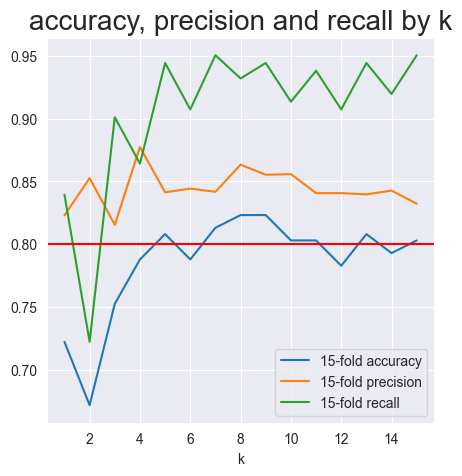

In [26]:
accuracy_f, precision_f, recall_f = [], [], []
for k in np.arange(1, 16):
    clf_2 = Pipeline(steps=[
        ("prep", data_prep),
        ("train", KNeighborsClassifier(n_neighbors=k))
    ])
    accuracy_f.append(cross_val_score(clf_2, x_f, y_f, cv=fold, scoring="accuracy", n_jobs=-1).mean())
    precision_f.append(cross_val_score(clf_2, x_f, y_f, cv=fold, scoring="precision", n_jobs=-1).mean())
    recall_f.append(cross_val_score(clf_2, x_f, y_f, cv=fold, scoring="recall", n_jobs=-1).mean())
plt.figure(figsize=[5, 5])
plt.plot(range(1,16), accuracy_f, label="15-fold accuracy")
plt.plot(range(1,16), precision_f, label="15-fold precision")
plt.plot(range(1,16), recall_f, label="15-fold recall")
plt.axhline(y=0.8, color="r")
plt.xlabel("k")
plt.title("accuracy, precision and recall by k", fontsize=20)
plt.legend()
plt.show()

In [27]:
pipeline_f = Pipeline(steps=[
    ("prep", data_prep),
    ("vote", VotingClassifier([("1st", KNeighborsClassifier(n_neighbors=4)), ("2nd", KNeighborsClassifier(n_neighbors=7)), ("3rd", KNeighborsClassifier(n_neighbors=9))]))
]).fit(x_f, y_f)
predict_f = pipeline_f.predict(test_f[["Pclass", "Embarked", "NFare"]])
data.loc[891:, "Predict"][(data["Sex"] == "female") & (data.WCLive.isnull())] = predict_f

All training finished.

In [28]:
submission = pd.DataFrame({"PassengerId": data[891:].PassengerId, "Survived": data[891:].Predict.astype("int")})
submission.to_csv("data/result/submission.csv", index=False)